#### script to run multiple regression analysis to find factors most influencing housing costs

view the relationships in greater detail with the [Shiny app](https://ukacz.shinyapps.io/cap-region-housing/)

In [2]:
library(car, warn.conflicts = FALSE)
library(leaps, warn.conflicts = FALSE)
library(corrgram, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(MASS, warn.conflicts = FALSE)

In [3]:
# read in combined H+T and EPA smart location data
all.data <- read.csv("all.data.csv", stringsAsFactors = FALSE)
attach(all.data)

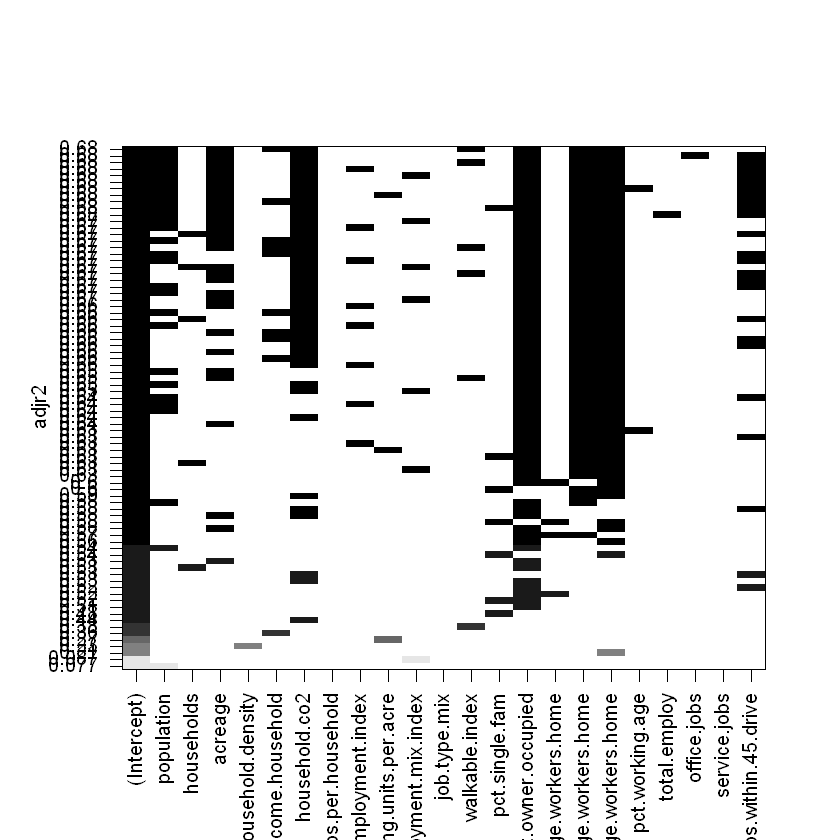

In [4]:
# variable selection using leaps best subset automatic method
# best subsets regression compares all possible regression models given specified params
# look at size of increase in adj r^2 when adding a variable

leaps <- regsubsets(housing.cost~
                      population +
                      households +
                      acreage +
                      gross.household.density +
                      autos.typical.income.household +
                      household.co2 +
                      jobs.per.household +
                      overall.employment.index +
                      housing.units.per.acre +
                      employment.mix.index +
                      job.type.mix +
                      walkable.index +
                      pct.single.fam +
                      pct.owner.occupied +
                      low.wage.workers.home +
                      med.wage.workers.home +
                      hi.wage.workers.home +
                      pct.working.age +
                      total.employ +
                      office.jobs +
                      service.jobs +
                      job.type.mix +
                      jobs.within.45.drive, data = all.data, method = "exhaustive", nbest = 10)

plot(leaps, scale = "adjr2")

In [5]:
# first model: no transformations
fit <- lm(housing.cost~
            population +
            acreage +
            household.co2 +
            walkable.index +
            pct.owner.occupied +
            med.wage.workers.home +
            hi.wage.workers.home +
            jobs.within.45.drive)

summary(fit)


Call:
lm(formula = housing.cost ~ population + acreage + household.co2 + 
    walkable.index + pct.owner.occupied + med.wage.workers.home + 
    hi.wage.workers.home + jobs.within.45.drive)

Residuals:
    Min      1Q  Median      3Q     Max 
-784.47 -146.81  -16.57  111.45 1427.81 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            4.013e+02  1.478e+02   2.714  0.00681 ** 
population             1.152e-01  2.790e-02   4.128 4.14e-05 ***
acreage               -1.189e-02  2.685e-03  -4.427 1.12e-05 ***
household.co2          6.103e+01  1.090e+01   5.600 3.16e-08 ***
walkable.index        -1.428e+01  9.847e+00  -1.451  0.14736    
pct.owner.occupied     5.386e+02  7.012e+01   7.682 5.73e-14 ***
med.wage.workers.home -1.840e+00  1.818e-01 -10.121  < 2e-16 ***
hi.wage.workers.home   8.806e-01  1.195e-01   7.366 5.29e-13 ***
jobs.within.45.drive   2.795e-03  6.109e-04   4.575 5.69e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.

population               acreage         household.co2 
             4.113568              2.488934              7.953036 
       walkable.index    pct.owner.occupied med.wage.workers.home 
             9.495486              4.279055              3.610007 
 hi.wage.workers.home  jobs.within.45.drive 
             4.937880              2.601192

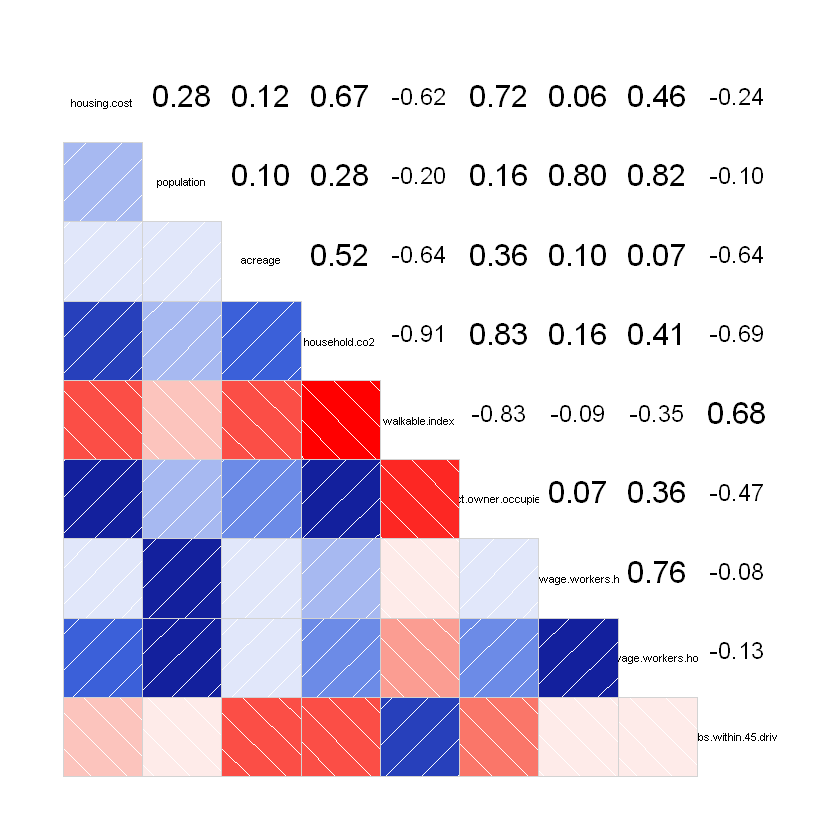

In [6]:
# tests for multicollinearity/correlations
vif(fit)

corr <- cor(all.data[c("housing.cost", "population", "acreage", "household.co2", "walkable.index", "pct.owner.occupied",
                       "med.wage.workers.home", "hi.wage.workers.home", "jobs.within.45.drive")], use = "complete")

corrgram(corr, lower.panel = panel.shade, upper.panel = panel.conf)

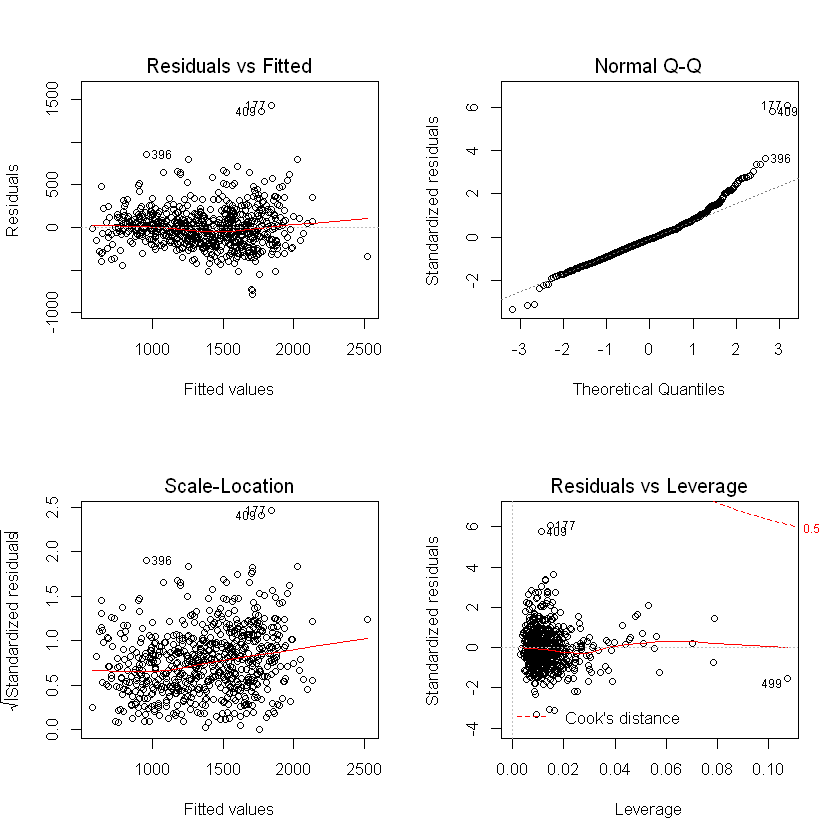

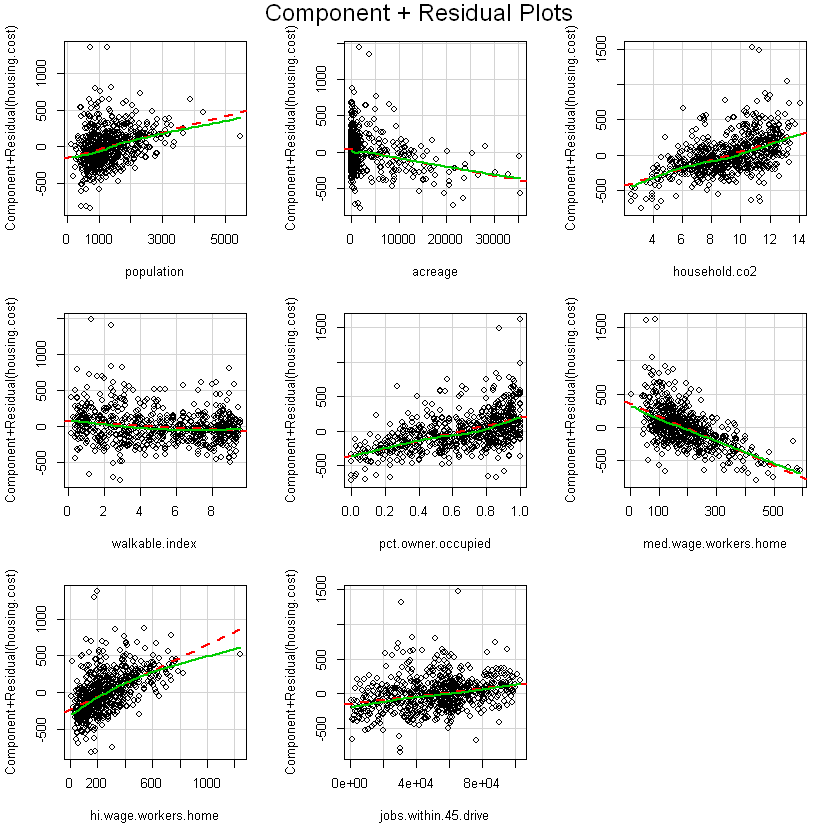

In [7]:
# model's diagnostic plots
# qq plot indicates nonnormal distribution of residuals (right skew)
par(mfrow = c(2, 2))
plot(fit)
crPlots(fit)

In [8]:
# transform housing cost variable to address fat tail residual distribution
# acreage, med wage, and jobs variables flipped signs (multicollinearity?)
# replace acreage with housing units per acre factor
# remove population and med.wage variables because of too high correlation coefficients
# model interaction of jobs within 45 drive variable with jobs per household in block group 

fit2 <- lm(sqrt(housing.cost) ~
             housing.units.per.acre +
             household.co2 +
             pct.owner.occupied +
             hi.wage.workers.home +
             (jobs.within.45.drive*sqrt(jobs.per.household))) # zero values: can't log transform

summary(fit2)


Call:
lm(formula = sqrt(housing.cost) ~ housing.units.per.acre + household.co2 + 
    pct.owner.occupied + hi.wage.workers.home + (jobs.within.45.drive * 
    sqrt(jobs.per.household)))

Residuals:
   Min     1Q Median     3Q    Max 
-9.880 -2.027 -0.218  1.731 15.963 

Coefficients:
                                                Estimate Std. Error t value
(Intercept)                                    1.378e+01  1.351e+00  10.199
housing.units.per.acre                        -4.899e-02  2.993e-02  -1.637
household.co2                                  1.112e+00  1.312e-01   8.476
pct.owner.occupied                             8.856e+00  8.916e-01   9.933
hi.wage.workers.home                           5.306e-03  8.515e-04   6.231
jobs.within.45.drive                           1.017e-04  9.938e-06  10.234
sqrt(jobs.per.household)                       2.917e+00  5.668e-01   5.146
jobs.within.45.drive:sqrt(jobs.per.household) -4.054e-05  7.921e-06  -5.118
                              

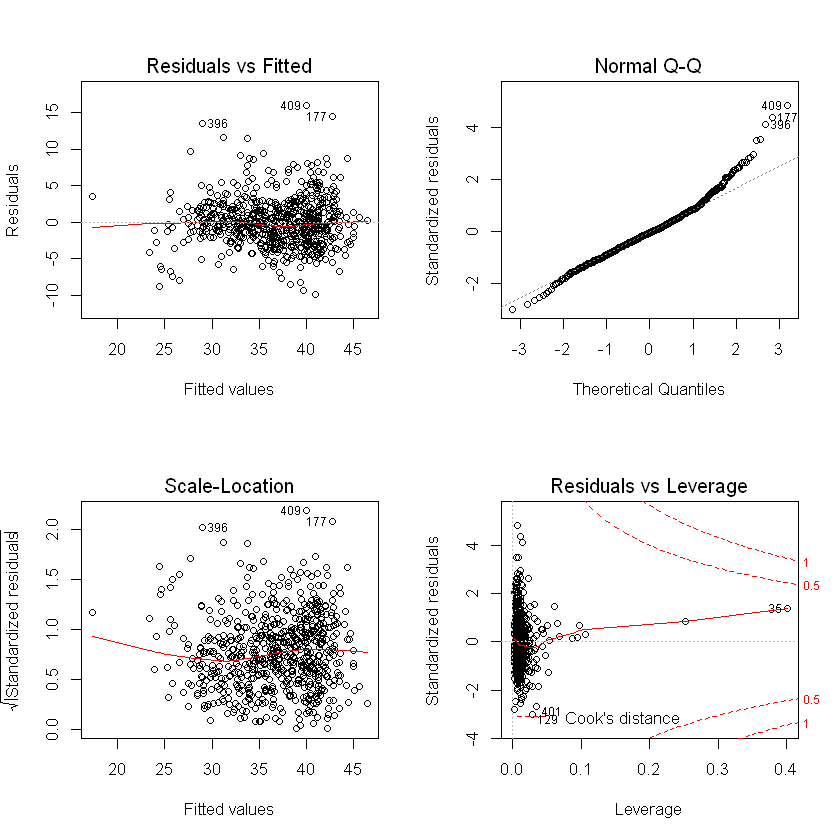

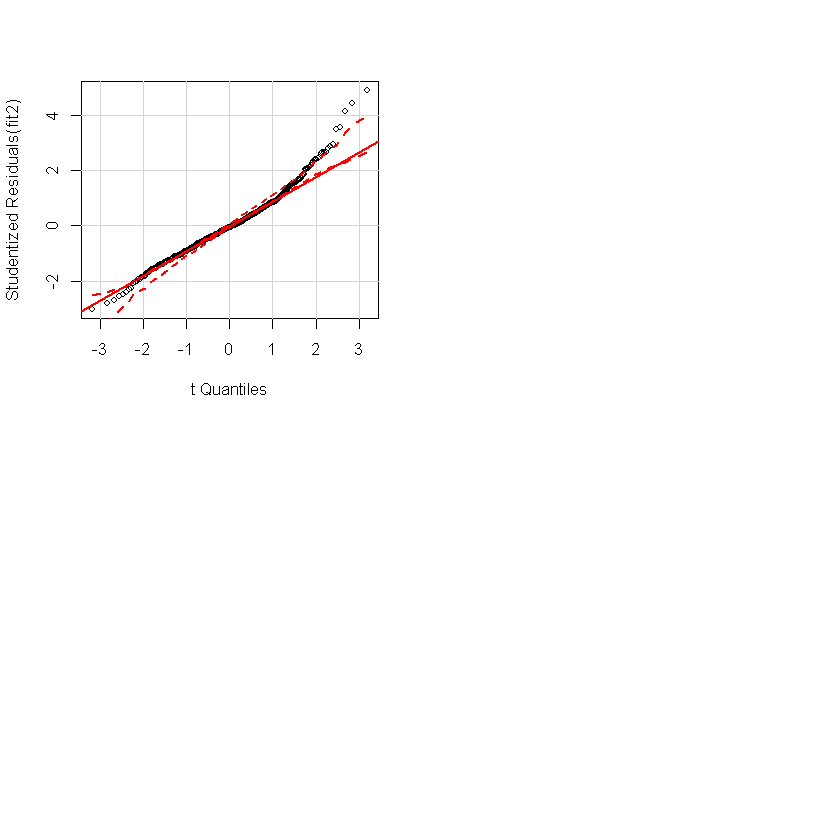

In [9]:
# diagnostic plots indicate homoscedastic residuals
# qq plot still shows heavy right tail
par(mfrow = c(2, 2))
plot(fit2)
qqPlot(fit2, envelope = .99)

In [10]:
# try generalized linear model with sqrt link function
fit3 <- glm(housing.cost ~
               housing.units.per.acre +
               household.co2 +
               pct.owner.occupied +
               hi.wage.workers.home +
               (jobs.within.45.drive*sqrt(jobs.per.household)), family = poisson(link = "sqrt"))

summary(fit3)


Call:
glm(formula = housing.cost ~ housing.units.per.acre + household.co2 + 
    pct.owner.occupied + hi.wage.workers.home + (jobs.within.45.drive * 
    sqrt(jobs.per.household)), family = poisson(link = "sqrt"))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-19.192   -4.304   -0.738    3.179   33.326  

Coefficients:
                                                Estimate Std. Error z value
(Intercept)                                    1.412e+01  2.031e-01   69.53
housing.units.per.acre                        -4.904e-02  4.501e-03  -10.89
household.co2                                  1.092e+00  1.973e-02   55.33
pct.owner.occupied                             8.964e+00  1.341e-01   66.86
hi.wage.workers.home                           5.129e-03  1.280e-04   40.06
jobs.within.45.drive                           1.005e-04  1.494e-06   67.23
sqrt(jobs.per.household)                       3.008e+00  8.522e-02   35.30
jobs.within.45.drive:sqrt(jobs.per.household) -4

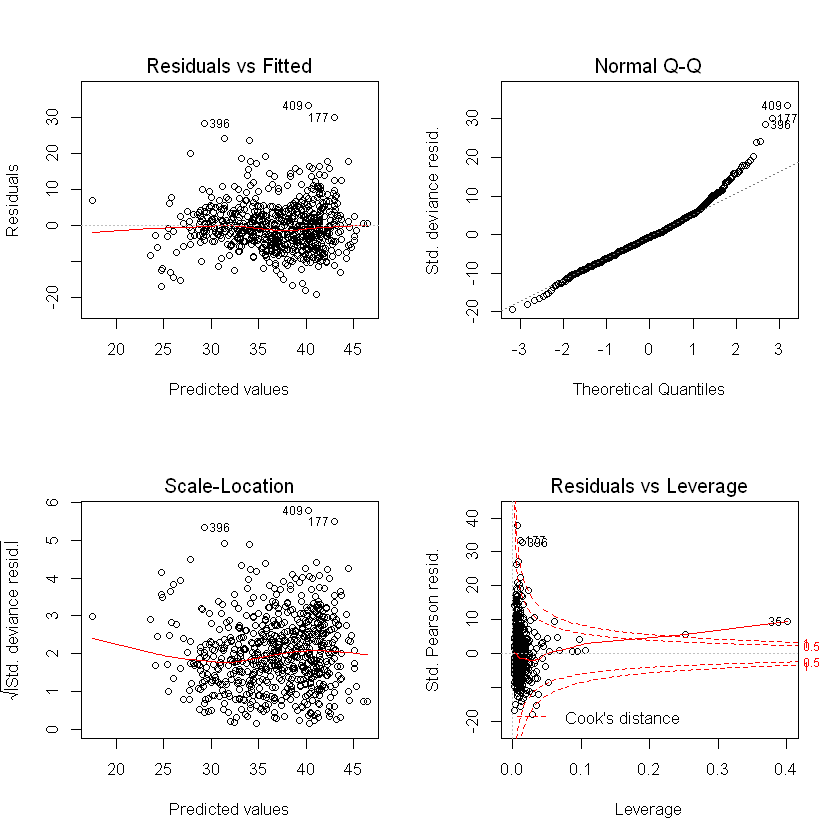

In [11]:
# diagnostic plots
## outlying residuals have too high leverage
par(mfrow = c(2, 2))
plot(fit3)

In [12]:
# try robust linear regression using huber weighting function to address heavy tail
fit4 <- rlm(housing.cost ~
              housing.units.per.acre +
              household.co2 +
              pct.owner.occupied +
              hi.wage.workers.home +
              (jobs.within.45.drive*sqrt(jobs.per.household)), k = 5)

summary(fit4)


Call: rlm(formula = housing.cost ~ housing.units.per.acre + household.co2 + 
    pct.owner.occupied + hi.wage.workers.home + (jobs.within.45.drive * 
    sqrt(jobs.per.household)), k = 5)
Residuals:
   Min     1Q Median     3Q    Max 
-718.0 -156.3  -26.4  114.9 1522.9 

Coefficients:
                                              Value     Std. Error t value  
(Intercept)                                   -262.4492  102.1047    -2.5704
housing.units.per.acre                          -1.7257    2.2624    -0.7628
household.co2                                   77.0377    9.9174     7.7679
pct.owner.occupied                             654.6040   67.3903     9.7136
hi.wage.workers.home                             0.3979    0.0644     6.1819
jobs.within.45.drive                             0.0071    0.0008     9.4831
sqrt(jobs.per.household)                       214.4777   42.8387     5.0066
jobs.within.45.drive:sqrt(jobs.per.household)   -0.0029    0.0006    -4.8575

Residual standard e

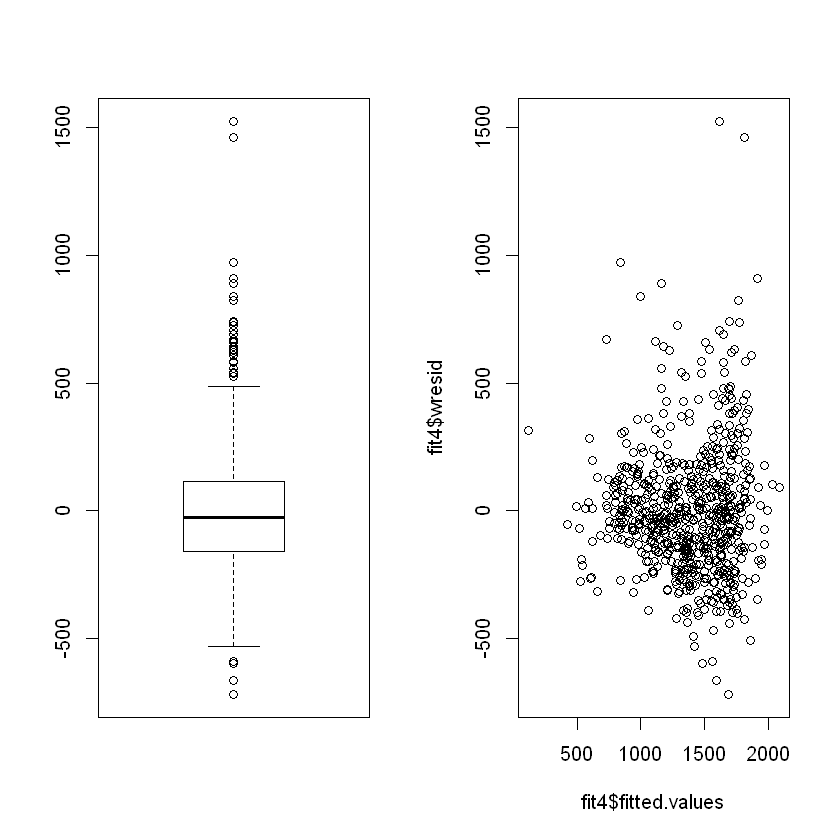

In [13]:
# plot model's residuals
par(mfrow = c(1, 2))
boxplot(fit4$wresid); plot(fit4$fitted.values, fit4$wresid)

In [14]:
# weighted model has increased reisdual variance and does not correct tails
# robust regression not a more reasonable estimator
fit.final <- lm(sqrt(housing.cost) ~
             housing.units.per.acre +
             household.co2 +
             pct.owner.occupied +
             hi.wage.workers.home +
             (jobs.within.45.drive*sqrt(jobs.per.household)))

summary(fit.final)


Call:
lm(formula = sqrt(housing.cost) ~ housing.units.per.acre + household.co2 + 
    pct.owner.occupied + hi.wage.workers.home + (jobs.within.45.drive * 
    sqrt(jobs.per.household)))

Residuals:
   Min     1Q Median     3Q    Max 
-9.880 -2.027 -0.218  1.731 15.963 

Coefficients:
                                                Estimate Std. Error t value
(Intercept)                                    1.378e+01  1.351e+00  10.199
housing.units.per.acre                        -4.899e-02  2.993e-02  -1.637
household.co2                                  1.112e+00  1.312e-01   8.476
pct.owner.occupied                             8.856e+00  8.916e-01   9.933
hi.wage.workers.home                           5.306e-03  8.515e-04   6.231
jobs.within.45.drive                           1.017e-04  9.938e-06  10.234
sqrt(jobs.per.household)                       2.917e+00  5.668e-01   5.146
jobs.within.45.drive:sqrt(jobs.per.household) -4.054e-05  7.921e-06  -5.118
                              

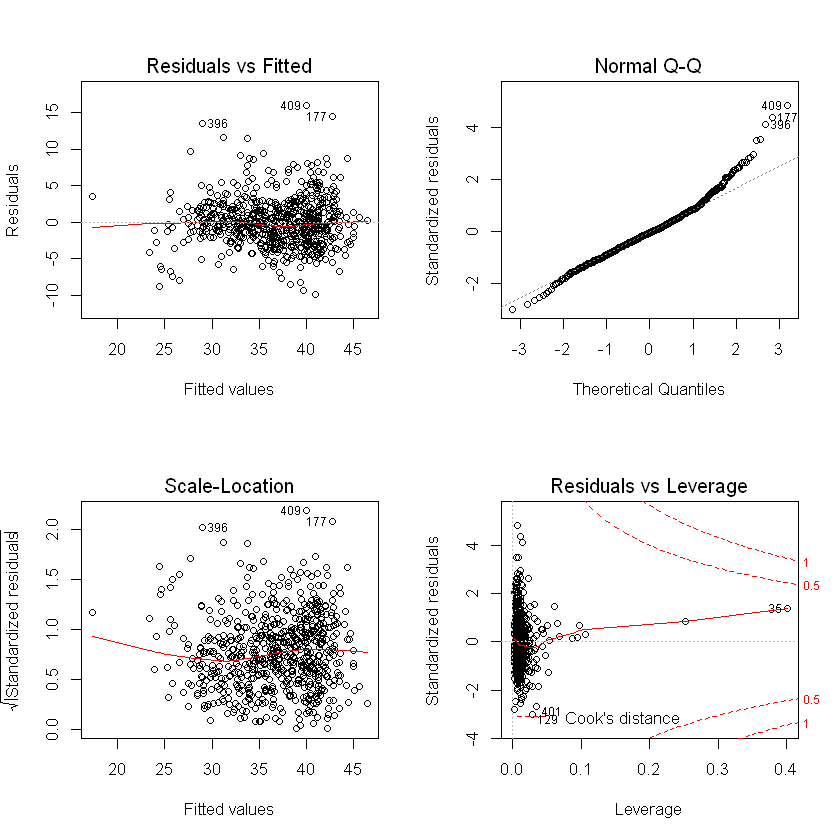

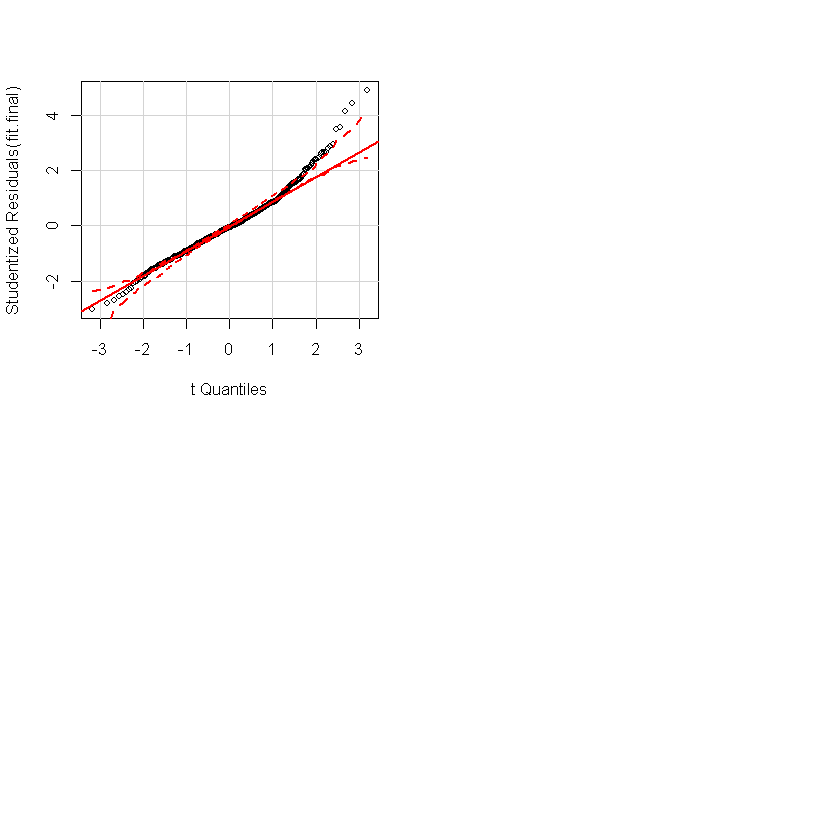

In [15]:
# final model diagnostics
par(mfrow = c(2, 2))
plot(fit.final)
qqPlot(fit.final, envelope = .99) # five outliers